In [25]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('notebook')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [2]:
ee_dense = pd.read_csv('densenet_all_inference_test.csv', index_col=0)
co_dense = 
ee_dense.mean()

threshold        0.500000
exit             0.953356
prediction      48.891356
target          49.500000
correct          0.800333
score_margin     0.785511
time             0.032141
dtype: float64

In [3]:
ee_dense = ee_dense.to_numpy()

In [5]:
ee_dense = pd.DataFrame(ee_dense[1:], columns=['threshold', 'exit', 'prediction', 'target', 'correct', 'score', 'time'])

In [6]:
ee_dense.mean()

threshold      0.500009
exit           0.953377
prediction    48.892442
target        49.501100
correct        0.800329
score          0.785513
time           0.032120
dtype: float64

In [8]:
len(ee_dense.loc[ee_dense['exit']==0])

17020

In [9]:
len(ee_dense.loc[(ee_dense['exit']==0) & (ee_dense['correct'] == False)])

3488

In [10]:
len(ee_dense.loc[ee_dense['exit']==1])

17154

In [11]:
len(ee_dense.loc[ee_dense['exit']==2])

6728

In [12]:
len(ee_dense.loc[ee_dense['exit']==3])

4097

In [13]:
len(ee_dense.loc[(ee_dense['exit']==3) & (ee_dense['correct'] == False)])

1759

In [14]:
len(ee_dense.loc[(ee_dense['correct'] == False)])

8985

In [16]:
arr = []

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in ee_dense.groupby(['threshold']):
    tmp = i[1].mean()
    arr.append((tmp.correct, tmp.time))

#sns.lineplot(data=i[1].mean().correct)
ee_dense_stats = pd.DataFrame(arr, columns=["Mean Accuracy", "Mean Time"], index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ee_dense_stats

,Mean Accuracy,Mean Time
0.1,0.656531,0.021872
0.2,0.724800,0.025096
0.3,0.766200,0.027767
0.4,0.796200,0.030118
0.5,0.823600,0.032195
0.6,0.841000,0.034569
0.7,0.854000,0.036443
0.8,0.866200,0.038817
0.9,0.874400,0.042203


# ResNet

In [18]:
ee_res = pd.read_csv('resnet101_all_inference_test.csv', index_col=0)
co_res = pd.read_csv('resnet_conv_inference_test.csv', index_col=0)
ee_res.correct = ee_res.correct.astype(int)
ee_res

,threshold,exit,prediction,target,correct,score_margin,time
0,0.1,0,0,0,1,0.204359,0.977127
1,0.1,0,0,0,1,0.989505,0.014066
2,0.1,0,0,0,1,0.357393,0.014050
3,0.1,0,0,0,1,0.870633,0.012749
4,0.1,0,0,0,1,0.660327,0.013005
5,0.1,0,0,0,1,0.799488,0.012808
6,0.1,0,0,0,1,0.999894,0.013275
7,0.1,0,0,0,1,0.998322,0.012334
8,0.1,1,0,0,1,0.962256,0.019159
9,0.1,0,92,0,0,0.110625,0.011794


In [19]:
co_res.mean().time

0.04474636967999995

In [20]:
ee_res = ee_res.to_numpy()

In [22]:
ee_res = pd.DataFrame(ee_res[1:], columns=['threshold', 'exit', 'prediction', 'target', 'correct', 'score', 'time'])

In [23]:
arr = []

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in ee_res.groupby(['threshold']):
    tmp = i[1].mean()
    arr.append((tmp.correct, tmp.time))

#sns.lineplot(data=i[1].mean().correct)
ee_res_stats = pd.DataFrame(arr, columns=["Mean Accuracy", "Mean Time"], index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ee_res_stats

,Mean Accuracy,Mean Time
0.1,0.645729,0.017184
0.2,0.735200,0.021034
0.3,0.788400,0.023683
0.4,0.822600,0.026222
0.5,0.848800,0.028200
0.6,0.866200,0.029933
0.7,0.875400,0.032040
0.8,0.884200,0.033742
0.9,0.890200,0.036733


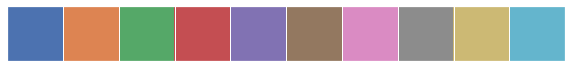

In [46]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

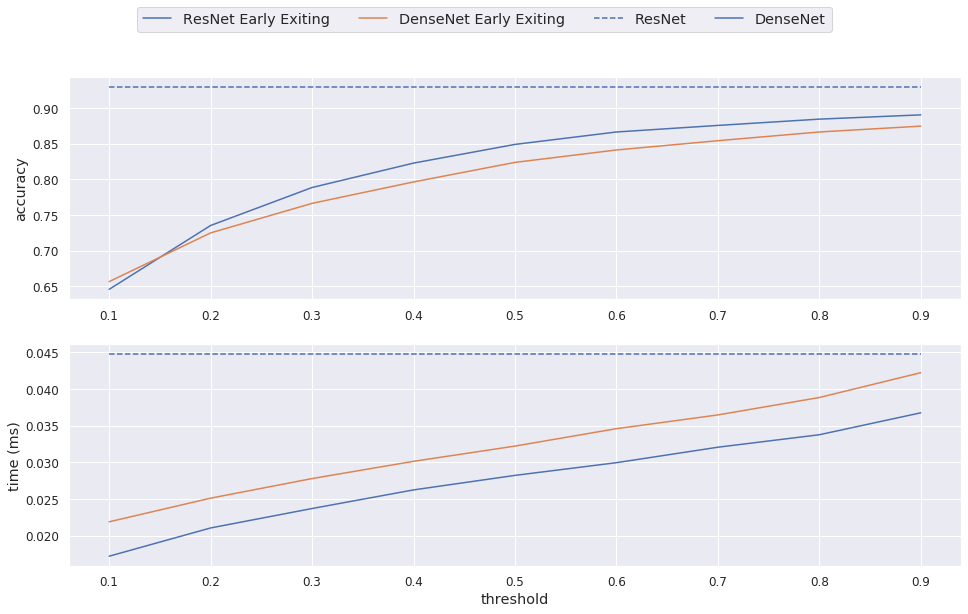

In [76]:
fig, axes = plt.subplots(2,1)
sns.lineplot(data=ee_res_stats['Mean Accuracy'], ax=axes[0], color=current_palette[0])
sns.lineplot(data=ee_res_stats['Mean Time'], ax=axes[1])

sns.lineplot(data=ee_dense_stats['Mean Accuracy'], ax=axes[0], color=current_palette[1])
sns.lineplot(data=ee_dense_stats['Mean Time'], ax=axes[1])
axes[0].set_ylabel('accuracy')
axes[1].set_ylabel('time (ms)')
plt.xlabel('threshold')
sns.lineplot(x=x, y=co_res.mean().correct*np.ones(9), ax=axes[0], color=current_palette[0])
sns.lineplot(x=x, y=co_res.mean().time*np.ones(9), ax=axes[1], color=current_palette[0])

#ns.lineplot(x=x, y=co_res.mean().correct*np.ones(9), ax=axes[0], dashes=True)
#sns.lineplot(x=x, y=co_res.mean().time*np.ones(9), ax=axes[1])


axes[0].lines[2].set_linestyle("--")

axes[1].lines[2].set_linestyle("--")


fig.legend(['ResNet Early Exiting', 'DenseNet Early Exiting', 'ResNet', 'DenseNet'], ncol=4, loc="upper center")
#ns.lineplot(data=arr[0], ax= axes[0])
#sns.lineplot(data=arr[1], ax=axes[1])

In [77]:
len(ee_res.loc[ee_res['exit']==0])

13389

In [78]:
len(ee_res.loc[(ee_res['exit']==0) & (ee_res['correct'] == False)])

3062

In [79]:
len(ee_res.loc[ee_res['exit']==1])

14011

In [80]:
len(ee_res.loc[ee_res['exit']==2])

14136

In [81]:
len(ee_res.loc[ee_res['exit']==3])

3463

In [82]:
len(ee_res.loc[(ee_res['exit']==3) & (ee_res['correct'] == False)])

1736

In [83]:
len(ee_res.loc[(ee_res['correct'] == False)])

8216

In [166]:
ee_res.groupby(['threshold', 'exit']).size()

threshold  exit
0.1        0.0     3297
           1.0     1252
           2.0      424
           3.0       26
0.2        0.0     2456
           1.0     1584
           2.0      875
           3.0       85
0.3        0.0     1940
           1.0     1704
           2.0     1184
           3.0      172
0.4        0.0     1571
           1.0     1717
           2.0     1448
           3.0      264
0.5        0.0     1285
           1.0     1708
           2.0     1653
           3.0      354
0.6        0.0     1029
           1.0     1673
           2.0     1853
           3.0      445
0.7        0.0      828
           1.0     1582
           2.0     2039
           3.0      551
0.8        0.0      615
           1.0     1489
           2.0     2220
           3.0      676
0.9        0.0      368
           1.0     1302
           2.0     2440
           3.0      890
dtype: int64

In [150]:
merged = pd.DataFrame({'idx': ['ResNet', 'DenseNet'], 'dfs':[ee_res, ee_dense]})
merged

,idx,dfs
0,ResNet,threshold exit prediction target co...
1,DenseNet,threshold exit prediction target correct...


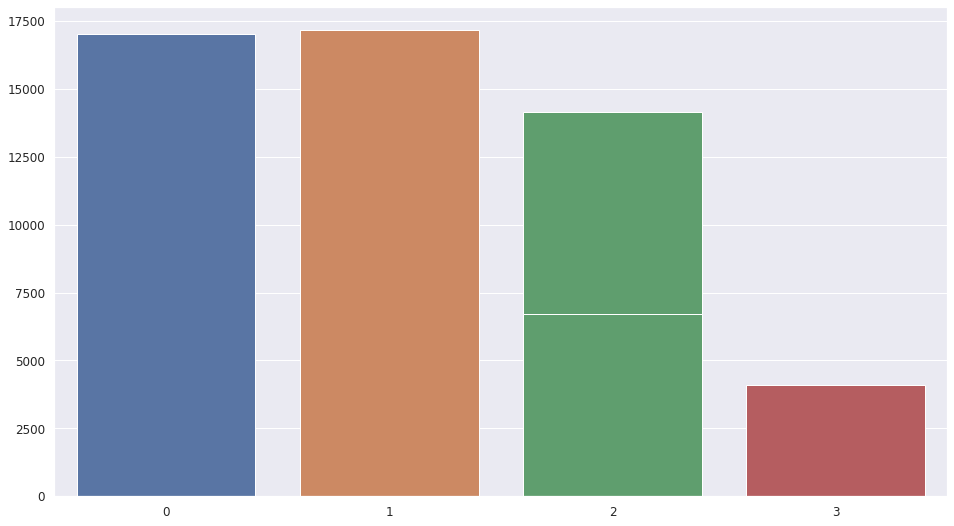

In [151]:
fig, axes = plt.subplots(1,1)
sns.barplot(x=np.arange(0,4,1), y=ee_res.groupby('exit').size(), ax=axes)
sns.barplot(x=np.arange(0,4,1), y=ee_dense.groupby('exit').size(), ax=axes)


In [279]:
ee_res.exit= ee_res.exit.astype('int')
d = { 'ResNet': ee_res.groupby(['threshold', 'exit']).size(),
     'DenseNet': ee_dense.groupby(['threshold', 'exit']).size() }
df = pd.DataFrame(d)

df = df / 5000
df

ResNet  DenseNet
threshold exit                  
0.1       0     0.6594    0.7392
          1     0.2504    0.2250
          2     0.0848    0.0324
          3     0.0052    0.0032
0.2       0     0.4912    0.5888
          1     0.3168    0.3262
          2     0.1750    0.0716
          3     0.0170    0.0134
0.3       0     0.3880    0.4912
          1     0.3408    0.3690
          2     0.2368    0.1066
          3     0.0344    0.0332
0.4       0     0.3142    0.4130
          1     0.3434    0.3950
          2     0.2896    0.1380
          3     0.0528    0.0540
0.5       0     0.2570    0.3452
          1     0.3416    0.4144
          2     0.3306    0.1626
          3     0.0708    0.0778
0.6       0     0.2058    0.2836
          1     0.3346    0.4298
          2     0.3706    0.1798
          3     0.0890    0.1068
0.7       0     0.1656    0.2358
          1     0.3164    0.4344
          2     0.4078    0.1956
          3     0.1102    0.1342
0.8       0     0.1230    0.1842
          1     0.2978    0.4294
          2     0.4440    0.2148
          3     0.1352    0.1716
0.9       0     0.0736    0.1230
          1     0.2604    0.4076
          2     0.4880    0.2442
          3     0.1780    0.2252

Text(0, 0.5, '% of samples exited')

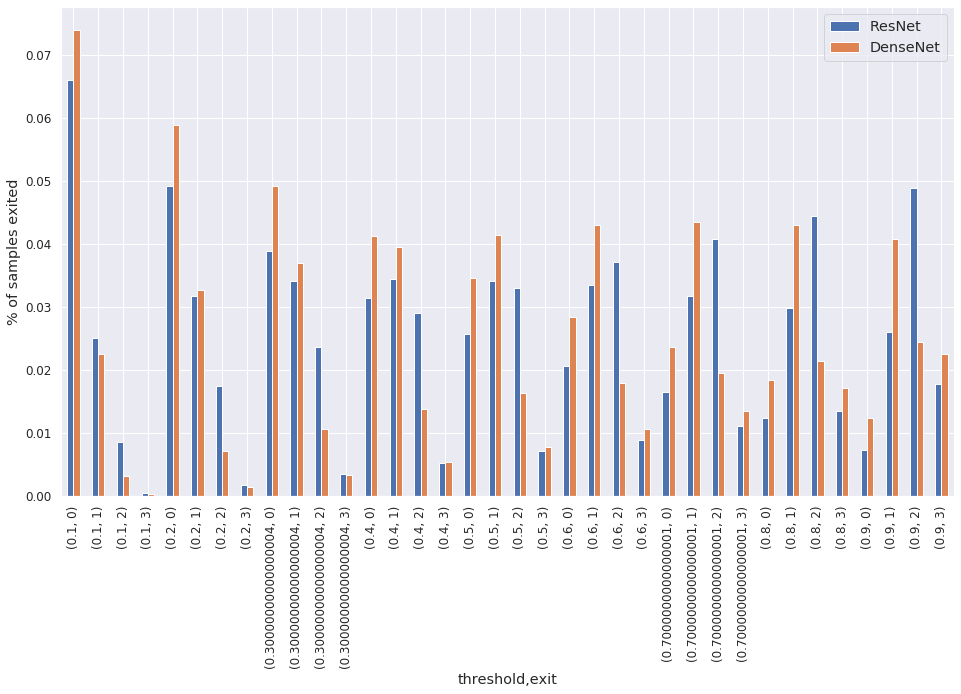

In [277]:
ax = df.plot(kind='bar')
ax.set_ylabel('% of samples exited')

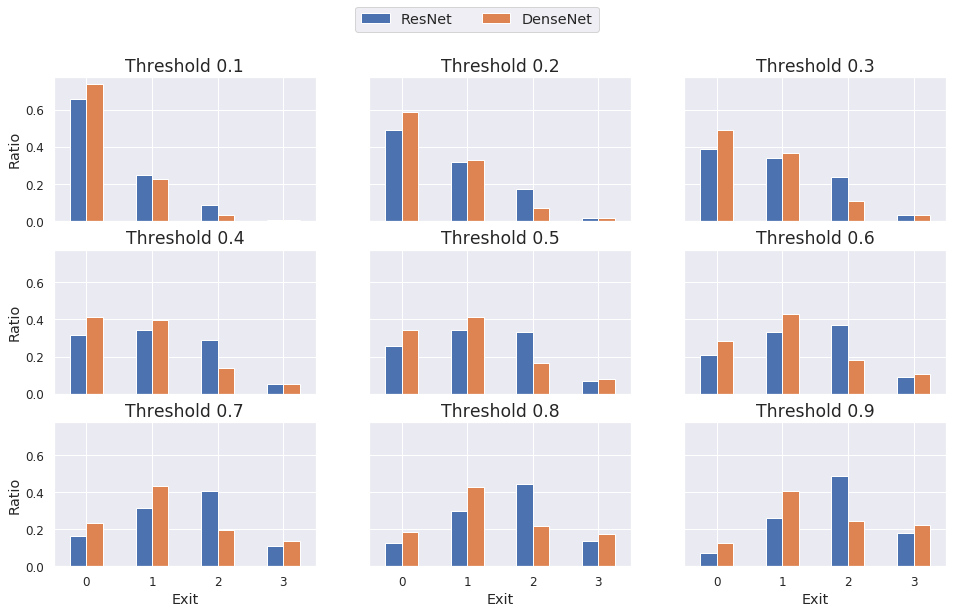

In [280]:
fig, axes = plt.subplots(3,3, sharex=True, sharey=True)
for i, data in zip(axes.flat, df.groupby('threshold')):
    i.set_title('Threshold {:0.1f}'.format(data[0]))
    data[1].plot(kind='bar', ax=i, legend=False)
    i.label_outer()
    #i.xtickslabels([1, 2, 3, 4])
    i.set(xlabel='Exit', ylabel='Ratio', xticks=[0,1,2,3])
    i.set_xticklabels([0,1,2,3])
    
    for tick in i.get_xticklabels():
        tick.set_rotation(0)
    
fig.legend(['ResNet', 'DenseNet'], ncol=2, loc='upper center')

